In [5]:
#importing the necessary dependencies

from caffe.proto import caffe_pb2
from layers import Fixations
# from urllib import urlretrieve
from utils import *
import caffe
import os

%matplotlib inline

In [6]:
#initializing the model

#Specifying to use the GPU
caffe.set_mode_gpu()
caffe.set_device(0)

net = caffe.Classifier('../models/resnet_101/deploy.prototxt','../models/resnet_101/ResNet-101-model.caffemodel',channel_swap=(2,1,0))
layers = Fixations(net)

In [7]:
def resnet(points, inc, resFac):
    points = layers.fc(points=points, layer='fc1000', prevLayer='pool5')
    points = layers.pool(points=points, prevLayer='res5c', K=7, S=1)
    blob_list = ['pool1', '2a', '2b', '2c', '3a', '3b1', '3b2', '3b3', '4a', '4b1', '4b2', '4b3', '4b4', '4b5', '4b6', '4b7', '4b8', '4b9',
         '4b10', '4b11', '4b12', '4b13', '4b14', '4b15', '4b16', '4b17', '4b18', '4b19', '4b20', '4b21', '4b22', '5a', '5b', '5c']
    for i in range(len(blob_list)-1,0,-1):
                points = layers.res(points, blob_list[i], blob_list[i-1])
    points = layers.pool(points=points, prevLayer='conv1',K=3, S=2)
    points = layers.conv(points=points,  layer='conv1', prevLayer='data', K=7, S=2, P=3)
    points = layers.data(points=points, inc=inc, resFac=resFac)
    return points
    

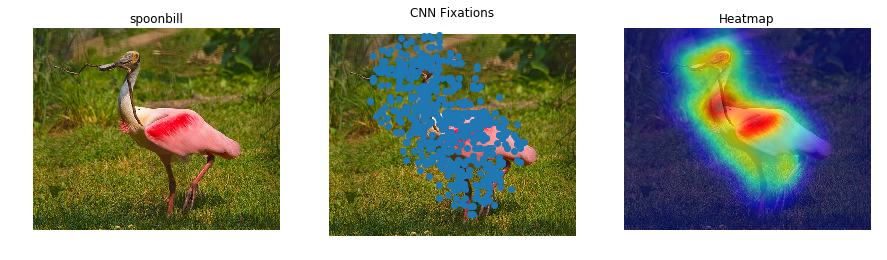

In [8]:
img_path = 'sample.jpg'
img, offset, resFac, newSize = imgPreprocess(img_path=img_path)
net.image_dims = newSize
points, image_label = pred(net, img)
# points = [0, 0, 0, 0, points[4]] # keep only center for fair comparision with tf resnet visualization
points = resnet(points, offset, resFac)
visualize(img_path, points, diag_percent=0.1, image_label=image_label)